# All Roads Lead to Kdb: the technical counterpart

This post serves as a follow-up to our prior article, [All Roads Lead to Kdb](https://www.habla.dev/blog/2023/07/31/all-roads-lead-to-pykx.html), where we introduced the utility of the PyKX library from the perspective of Emma Monad, the CTO of a large fictional company known as Mad Flow. In complement to this high-level perspective, the focus of this post is on Pythonist programmers who are eager to explore the technical intricacies that were left unexplained in the aforementioned article. Our fictional characters, Eloy, Jesús, and Félix, will assist us in comprehending both the objectives of Mad Flow's traffic improvement use case and the technical nuances of PyKX's role within it. In a manner similar to the outcomes presented in this [post](https://kx.com/blog/accelerating-python-workflows-using-pykx/) on the [KX developer blog](https://kx.com/resources/developer-blog/) by Morrison and Crone (which we highly recommend reading), we will observe a significant performance advantage of the resulting PyKX code compared to the initial Pandas implementation.

The structure of the post will be as follows:

* [**The Use Case**](#t2): We will begin by explaining the traffic improvement use case itself, encompassing its objectives, data sources, and anticipated outcomes. This section will also include references to the necessary data sources required to execute all the code provided in this notebook.
* [**PyKX migration**](#t3): Subsequently, we will demonstrate how to delegate resource-intensive processing to kdb+/q using PyKX, all while remaining within the Python environment! This Pythonic version powered by PyKX is likely the quickest route to start leveraging the capabilities of the kdb+/q environment.
* [**pykx.q migration**](#t4): Lastly, we will delve into the process of transitioning the code to pure kdb+/q, while continuing to utilize PyKX to retain the Pythonic code you wish to preserve. This kdb+/q version enhanced by PyKX is presented for those interested in a more extensive adoption of kdb+/q.
    
## Use Case<a class="anchor" id="t2"></a>

With the aim of predicting traffic congestion in the presence of rain, Mad Flow dedicated significant effort to preparing and integrating weather and traffic data into an LSTM model. This endeavor aligned with other [studies](https://www.mdpi.com/1424-8220/20/13/3749) that sought to forecast traffic patterns using LSTM models based on air pollution. In a manner akin to findings from studies conducted in cities such as [Manchester](https://pure.manchester.ac.uk/ws/portalfiles/portal/72721911/DEXA_Camera_8_pages.pdf), [Shenzhen](https://ieeexplore.ieee.org/document/8964560) and [Belgrade](https://www.safetylit.org/citations/index.php?fuseaction=citations.viewdetails&citationIds[]=citjournalarticle_716898_14), our results project a weekday traffic volume increase of 5-15% during peak hours in the presence of rain.

As is customary in projects associated with smart cities, the data exhibits notable heterogeneity, necessitating substantial preparatory work. The following sections will detail the data sources, the cleansing and interpretation processes, as well as the model employed.

### Data sources <a class="anchor" id="t21"></a>

The [Madrid City Council](https://datos.madrid.es/portal/site/egob) provides weather and traffic data, encompassing both real-time and historical records. For the purpose of model training, only the historical data is pertinent. These datasets, formatted as CSV files, are categorized by months spanning from the year 2018 to the present.

<div class="alert alert-block alert-info">
    <b> 🔍 You can access the different datasets required to run this notebook from the following links: 
        <ul>
            <li> <a href="https://datos.madrid.es/egob/catalogo/300352-141-meteorologicos-horarios.csv">Weather data</a>
            <li> <a href="https://datos.madrid.es/egob/catalogo/300360-1-meteorologicos-estaciones.csv">Weather stations</a>
            <li> <a href="https://datos.madrid.es/egob/catalogo/208627-115-transporte-ptomedida-historico.zip">Traffic data</a>
            <li> <a href="https://datos.madrid.es/egob/catalogo/202468-170-intensidad-trafico.csv">Traffic stations</a>
        </ul>
    </b>
</div>



**Weather data**

The table below provides a snapshot of the type of information available in the [weather dataset](https://datos.madrid.es/egob/catalogo/300352-141-meteorologicos-horarios.csv):

|    |   weather_station |   magnitude |   year |   month |   day |    H01 | V01   | ...|
|---:|------------------:|-----------:|-------:|--------:|------:|-------:|------:|:------|
|  0 |               108 |         81 |   2022 |      12 |    22 |  270   | N     | ...|
|  1 |               108 |         82 |   2022 |      12 |    22 |    9   | N     |...|
|  2 |               108 |         83 |   2022 |      12 |    22 |   94.7 | N     |...|
|  3 |               108 |         86 |   2022 |      12 |    22 | 1031   | N     |...|
|  4 |               108 |         87 |   2022 |      12 |    22 |    2   | N     |...|

This dataset contains hourly meteorological observations, including temperature, humidity, wind speed, and precipitation measurements.

Each row documents various details about a specific meteorological station:

* The 'magnitude' field denotes the type of meteorological data captured in the corresponding row (e.g., 81 - wind, 82 - direction, ..., 89 - rainfall).
* In the 'H01' and 'V01' columns, the value for the data type specified in the 'magnitude' column is provided, along with its validity status, respectively.
* The 'year', 'month', and 'day' columns indicate the timestamp of the measurement recording.

Furthermore, we will require the geographical coordinates of the various stations, which are available in a distinct [table](https://datos.madrid.es/egob/catalogo/300360-1-meteorologicos-estaciones.csv) provided by the Madrid City Council.

|    |   weather_station |   Longitude |   Latitude |
|---:|------------------:|------------:|-----------:|
|  0 |                 4 |    -3.71226 |    40.4239 |
|  1 |                 8 |    -3.68232 |    40.4216 |
|  2 |                16 |    -3.63924 |    40.44   |
|  3 |                18 |    -3.73184 |    40.3948 |
|  4 |               108 |    -3.717881|    40.47663|

**Traffic data**

The traffic sensors are strategically positioned at traffic lights throughout the city of Madrid. The collected data encompasses diverse measurements of road conditions, including speed and traffic volume. All of these metrics are encapsulated in the 'load' metric, depicted as a percentage that quantifies congestion. The format of the [traffic table](https://datos.madrid.es/egob/catalogo/208627-115-transporte-ptomedida-historico.zip) is presented as follows: 

|    |   traffic_station | tipo_elem   |   intensidad |   ocupacion |   load |   vmed | error   |   periodo_integracion | date                |
|---:|------------------:|:------------|-------------:|------------:|-------:|-------:|:--------|----------------------:|:--------------------|
|  0 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:00:00 |
|  1 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:15:00 |
|  2 |              1001 | M30         |          300 |           1 |      0 |     66 | N       |                     5 | 2022-12-01 00:30:00 |

This table encompasses information from various traffic stations, detailing elements such as traffic intensity, occupancy, congestion load, and other relevant data, all correlated with specific dates and times.

The table also includes a column for the date and another column that identifies the sensor. This identification will be used to establish a link with its corresponding coordinates by utilizing the subsequent [traffic stations table](https://datos.madrid.es/egob/catalogo/202468-170-intensidad-trafico.csv):

|    | "tipo_elem"   |   "distrito" |   "id" | "cod_cent"   | "nombre"                                                          |   "utm_x" |     "utm_y" |   Longitude |   Latitude |
|---:|:--------------|-------------:|-------:|:-------------|:------------------------------------------------------------------|----------:|------------:|------------:|-----------:|
|  0 | "URB"         |            4 |   3840 | "01001"      | "Jose Ortega y Gasset E-O - Pº Castellana-Serrano"                |    441615 | 4.47577e+06 |    -3.68832 |    40.4305 |
|  1 | "URB"         |            4 |   3841 | "01002"      | "Jose Ortega y Gasset O-E - Serrano-Pº Castellana"                |    441706 | 4.47577e+06 |    -3.68726 |    40.4305 |
|  2 | "URB"         |            1 |   3842 | "01003"      | "Pº Recoletos N-S - Almirante-Prim"                               |    441319 | 4.47484e+06 |    -3.69173 |    40.4221 |

    
### Data Cleaning  <a class="anchor" id="t22"></a>

Upon loading the data, the subsequent task involved its preparation for analysis and modeling. Given the diverse nature of the datasets, the process of data cleaning will be conducted individually for each dataset. The eventual consolidation of this cleaned data into a unified table will occur during a subsequent phase.

#### Weather Data

The process employed to clean the weather dataset involves the following steps:

1. In the weather dataset, the date is initially segregated into distinct columns for day, month, and year. However, the traffic dataset presents these data in a concatenated form. Consequently, the columns have been amalgamated to generate a unified 'date' column with the format: ```day-month-year```. 

2. Additionally, each hourly measurement value and its corresponding validity status are transformed into separate rows. Concurrently, this presents an opportunity to eliminate any measurements that are deemed invalid:

|       | hour            |   value |
|------:|:----------------|--------:|
|     0 | 0 days 00:00:00 |    7.1  |
|     1 | 0 days 00:00:00 |    6.8  |
|     2 | 0 days 00:00:00 |    2.8  |
|     3 | 0 days 00:00:00 |    5.6  |

3. To standardize the time measurement format and align it with the traffic table, we merge the date with the time. As a result, the updated date format becomes:```date-month-year hour:minute:second```

4. Lastly, we restructure the diverse types of measurements into distinct columns, enhancing the organizational coherence of the dataset:

|      | date                |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |
|-----:|:--------------------|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|
|    0 | 2022-12-01 00:00:00 |                 4 |           0 |          0 |          0 |        0   |       0 |           7.1 |   0    |
|    1 | 2022-12-01 00:00:00 |                 8 |           0 |         67 |          0 |        0   |       0 |           9.4 |   0    |
|    2 | 2022-12-01 00:00:00 |                16 |           0 |         73 |          0 |        0   |       0 |           8.9 |   0    |

#### Traffic Data

Concerning the traffic dataset, the procedures undertaken were as follows:

1. Initially, values characterized by measurement errors are excluded from consideration. The documentation designates these values using the symbol "N".

2. Subsequently, solely the load measurements, which constitute the focus of our analysis, are retained.

3. The data is then grouped based on each date and station, subsequently computing the average load value for each group.

| id   | fecha                         | tipo_elem | intensidad | ocupacion | carga | vmed | error | periodo_integracion |
|-----:|:------------------------------|----------:|-----------:|----------:|------:|-----:|------:|--------------------:|
| 1001 | 2022.12.01D00:00:00.000000000 |       M30 | 3240       | 9         | 0     | 59   | N     | 5                   |
| 1001 | 2022.12.01D00:15:00.000000000 |       M30 | 3240       | 9         | 0     | 59   | N     | 5                   |
| 1001 | 2022.12.01D00:30:00.000000000 |       M30 | 300        | 1         | 0     | 66   | N     | 5                   |

#### Location Data

To facilitate the integration of the aforementioned tables, it is imperative to establish a correspondence between the traffic sensors and the weather stations. This objective can be accomplished through the utilization of a distance matrix, which aids in identifying the nearest pairs encompassing both station types. While a direct measurement of this distance employing coordinates is feasible, we have opted for the utilization of the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). This distance calculation method computes the distance in meters between pairs of coordinates, furnishing a more lucid representation of distances.

This visualization is most effectively conveyed through the utilization of a heatmap, wherein the distances are depicted across a spectrum spanning from 0 to 20 kilometers:

<figure>
<img src="image_source/heatmap3.png">
<figcaption style = "text-align: center"> <b>Figure 1:</b> Heatmap of distances in km between weather and traffic stations </figcaption>
</figure>
    
#### The Final Table <a class="anchor" id="t23"></a>

Upon the completion of the preparatory steps for the three tables - weather, traffic, and distance - we proceed to merge them. Given the disparity in time intervals between the weather table (1 hour) and the traffic data (15 minutes), we will effectuate this merger utilizing an 'asof' join approach. Subsequently, we can augment the dataset with time and day-of-the-week information, enabling us to analyze the intricate relationship between these factors and traffic congestion.

|    | date                |   traffic_station |   load |   Distance |   Closest |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |   weekday |   hour |
|---:|:--------------------|------------------:|-------:|-----------:|----------:|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|----------:|-------:|
|  0 | 2022-12-01 00:00:00 |              1001 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  1 | 2022-12-01 00:00:00 |              1002 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  2 | 2022-12-01 00:00:00 |              1003 |      0 |         14 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  3 | 2022-12-01 00:00:00 |              1006 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  4 | 2022-12-01 00:00:00 |              1009 |      0 |         14 |         0 |                 4 |           0 |          0 |          0 |          0 |       0 |           7.1 |      0 |         3 |      0 |
    

### Data interpretation <a class="anchor" id="t24"></a>

Traffic patterns exhibit a pronounced dependency on time. To gain deeper insights into the data, a filtering process will be applied to extract instances of peak traffic, characterized by intensified congestion. This refined dataset will contribute to a more comprehensive understanding of the traffic dynamics. Notably, weekdays exhibit a greater traffic volume in contrast to holidays, and similarly, daytime hours experience heightened traffic flow relative to nighttime.

The subsequent figure illustrates the conspicuous seasonality evident within the dataset:
<table>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="image_source/loadperhour.png">
<figcaption style = "text-align: center">   <b>Figure 2:</b> Load per Hour </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="image_source/loadperweekday.png">
<figcaption style = "text-align: center">   <b>Figure 3:</b> Load per Weekday </figcaption>
</figure>
            </td>
    </tr>
</table>

Concerning the relationship between Rainfall and Load, preliminary observations indicate a limited occurrence of rainy days within our dataset:

|       |       rainfall |
|:------|---------------:|
| count | 841068         |
| mean  |      0.0130932 |
| std   |      0.194232  |
| min   |      0         |
| 50%   |      0         |
| 90%   |      0         |
| 99.9% |      2.9       |
| max   |     10.9       |

Upon scrutinizing the percentiles of the precipitation column, it becomes apparent that instances of recorded rainfall are relatively scarce. To contend with this limitation, measurements were stratified into discrete classes, contingent on the intensity of rainfall. As a result, a distinct analysis was undertaken for datasets encompassing heavy rain, moderate to light rain, and instances of no rain. This analysis was conducted on an hourly basis, mitigating the temporal influence on traffic patterns.

The outcomes of this analysis reveal that the average escalation in traffic congestion during rainy hours fluctuates between 5% and 14%, consistently aligning with the findings outlined in the Use Case section.

<figure>
<img src="image_source/rainfall.png">
<figcaption style = "text-align: center"> <b>Figure 4:</b> The average traffic load per hour for measurements categorized as heavy rain (blue), moderate rain (brown), and no rain (green):</figcaption>
</figure>

To ascertain the statistical significance of the disparities between these groups, an analysis of variance (ANOVA) test can be executed. Notably, the outcomes of the ANOVA test indicate substantial evidence of distinct variations in load levels across the various rain intensity categories for all hours. For instance, consider the results for hour 12:

|             |          sum_sq |    df |        F |       PR(>F) |
|:------------|----------------:|------:|---------:|-------------:|
| C(rainfall) | 37650.7         |     6 |  20.1144 |   1.3346e-23 |
| Residual    |     8.01363e+06 | 25687 | nan      | nan          |

The decision was made to incorporate rainfall as a factor within the model. In contrast, the remaining meteorological conditions did not exhibit comparably definitive outcomes; consequently, they were omitted from the model.

### The Model <a class="anchor" id="t25"></a>

For the purpose of performance evaluation, a preliminary model was developed employing a basic Long Short-Term Memory (LSTM) architecture with a memory span of 5 steps. The model's objective is to forecast the load at a specific traffic station. The model input encompasses historical load data, rainfall measurements, as well as the hour and day of the week.

Preliminary results derived from a single station exhibit promising outcomes, as demonstrated in Graph 6. Furthermore, an analysis of the training and validation loss curves indicates that the model neither encounters overfitting nor underfitting issues.

(TBD: Sacar las gráficas con ejes  y título)

<table> <a class="anchor" id="Image61"></a>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="image_source/loss_graph_p.png">
<figcaption style = "text-align: center">   <b>Figure 5:</b> Train vs Test loss plot  </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="image_source/fc_p.png">
<figcaption style = "text-align: center">   <b>Figure 6:</b> Traffic Forecasting for a traffic station </figcaption>
</figure>
            </td>
    </tr>
</table>


## PyKX migration <a class="anchor" id="t3"></a>

Despite the promising forecasting results yielded by the LSTM model, certain considerations arose concerning the efficiency of the Python code employed for project implementation. After profiling the entirity of the process, we found 3 key areas in which the code was behaving worse than expected:

| Action           | Pandas Time      |
| ---------------- | ---------------- |
| Cleaning Weather | 247 ms ± 10.4 ms |
| Cleaning Traffic | 33.6 s ± 493 ms  |
| Join Final Table | 7.1 s ± 168 ms   |

With this in mind, we primarily focused on these areas since those were where we should see the biggest improvement on performance. However, as the PyKX team [recommends](https://code.kx.com/pykx/1.6/user-guide/advanced/performance.html), it's best to keep as much as possible under PyKX to avoid performance overheads when dealing with moving data between memory spaces, so a full migration needed to be done.

This section will provide an elaborate account of how PyKX proved instrumental in the alleviation of resource-intensive processing by offloading tasks to the kdb+/q environment.

<div class="alert alert-block alert-info">
    <b> 🔍 You can find on Github the <a href="https://github.com/hablapps/AllRoadsLeadToPyKX/blob/Python-Version-Pre/AllRoadsLeadToPyKX.md">Original Python Project</a> that will be migrated into PyKX. </b>
</div>


First of all we need to install and import PyKX:

In [1]:
!pip install pykx

Keyring is skipped due to an exception: 'keyring.backends'


In [1]:
import pykx as kx

<div class="alert alert-block alert-info">
<b> 🔍 A license is required to use some of the following features. You can find more information in the <a href="https://code.kx.com/pykx/1.6/getting-started/installing.html">
    PyKX installation documentation</a>. </b>
</div> 

## Datasets <a class="anchor" id="t31"></a>

Before continuing, be sure to download the [datasets](#t21) required for running the next pieces of code.

#### Traffic

The preprocessing of the traffic table was one of the most critical parts in terms of time. Later on, we will showcase the improvement in execution time compared to our pure Pandas implementation.

The data loading will be executed employing the utilities facilitated by [PyKX](https://code.kx.com/pykx/1.4/api/read.html):

(TBR: Mirar este párrafo que lo he hecho rápido):

In [47]:
traffic = kx.q.read.csv('../12-2022.csv', types="IPSIIIISI", delimiter=';')

In [48]:
kx.q('system"c 4 250"')

pykx.Identity(pykx.q('::'))

In [52]:
kx.q("select from weather_station where weather_station=108")

pykx.Table(pykx.q('
weather_station longitude latitude
----------------------------------
108             -3.717881 40.47663
'))

In [49]:
print(traffic)

id   fecha                         tipo_elem intensidad ocupacion carga vmed error periodo_integracion
------------------------------------------------------------------------------------------------------
1001 2022.12.01D00:00:00.000000000 M30       3240       9         0     59   N     5                  
1001 2022.12.01D00:15:00.000000000 M30       3240       9         0     59   N     5                  
1001 2022.12.01D00:30:00.000000000 M30       300        1         0     66   N     5                  
1001 2022.12.01D00:45:00.000000000 M30       300        1         0     66   N     5                  
1001 2022.12.01D01:00:00.000000000 M30       300        1         0     66   N     5                  
..


<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%;">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;MORE INFO: <a href="https://code.kx.com/pykx/1.6/api/read.html">PyKX Read/Write Utils </a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> PyKX provides an array of functions designed to facilitate data loading and writing tasks. These functions encompass the capability to handle diverse file types, spanning both general formats and those specific to the q language. Notably, the q-specific functionalities enable seamless transfer of tables between the q context and the Python context, offering a bidirectional exchange of data. </p>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5">Specifically, the parameters of the read.csv function adhere to conventional standards. The file's URL and delimiter are specified. It is important to emphasize the types parameter, which expects the q <a href="https://code.kx.com/q/basics/datatypes/">types</a> associated with each column. 
</p>
</div>
</div>

As a result of this process, our table is now a PyKX object:

In [3]:
type(traffic)

pykx.wrappers.Table

Let's examine the initial few rows of this table:

In [4]:
print(traffic[:3])

id   fecha                         tipo_elem intensidad ocupacion carga vmed ..
-----------------------------------------------------------------------------..
1001 2022.12.01D00:00:00.000000000 M30       3240       9         0     59   ..
1001 2022.12.01D00:15:00.000000000 M30       3240       9         0     59   ..
1001 2022.12.01D00:30:00.000000000 M30       300        1         0     66   ..


<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%;">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;MORE INFO: <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/indexing.html">Use pythonic indexing </a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> Accessing data within PyKX objects, be it lists or tables, follows a methodology analogous to that of Numpy or Pandas. This facilitates the indexing of PyKX objects without necessitating the explicit utilization of q functions. Furthermore, the capacity to index by columns is an additional convenience offered by this approach.</p>        
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> print(weather["H01"][:3]) 
<div style="color:#808080;display:inline;"> 270 9 94.7 </div></code><br>   
</div>
</div>

We have the `kx.q.qsql` interface integrated in PyKX, which allows us to query into q tables concisely.

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%;">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;MORE INFO: <a href="https://code.kx.com/pykx/1.6/api/read.html">qSQL</a> and  <a href="https://code.kx.com/pykx/1.6/api/read.html">SQL</a> querys
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> PyKX allows you to use qSQL queries using API functions. This includes <code>select</code>, <code>`exec</code>, <code>`update</code> and <code>`delete</code> functions, which share some common characteristics, mainly with the arguments they receive. The first three share roughly this function call structure:
</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> kx.q.qsql.{function}({tab}, columns=..., where=..., by=...) </code>
<br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5">The <code>columns</code> argument expects either a list of strings or a dictionary where the key is the column name and the value is the actual value you want in this column if let's say you want to apply a function to it. Let's see an example:</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> >>> print(kx.q.qsql.select(weather, {"magnitude": "count distinct magnitude"}, by=["weather_station"])[:3])
<br><div style="color:#808080;display:inline;"> weather_station| magnitude
 ---------------| ---------
 4              | 1        
 8              | 2        
 16             | 2     
</div>         
</code>
<br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> But if you are more familiarized with the q environment it is also possible to use q functions. This approach reduces the verbosity of our functions compared to the equivalent in Python.
</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> >>> print(kx.q("{select count distinct magnitude by weather_station from x}", weather)[:3])
<br> <div style="color:#808080;display:inline;">weather_station| magnitude
 ---------------| ---------
 4              | 1        
 8              | 2        
 16             | 2 
</div>    
</code>
<br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> PyKX lets you use SQL queries too! </p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> >>> print(kx.q.sql("SELECT weather_station, COUNT(DISTINCT(magnitude)) FROM &#36 1 GROUP BY weather_station", weather)[:3])
<br> <div style="color:#808080;display:inline;">weather_station magnitude
 -------------------------
 4               1        
 8               2        
 16              2             
</div></code>
<br>
</div>
</div>

To preprocess the traffic table our objective is to ascertain the average load based on date and season, while eliminating measurement errors. The prowess of qSQL enables us to accomplish this feat through a singular query:

In [5]:
traffic = kx.q.qsql.select(traffic,
                         columns = {'traffic_load': 'avg carga'},
                         by = {"date":'fecha', "traffic_station": 'id'}, 
                         where = "error=`N")

Although it may look like a simple query, it is performing a seriously heavy operation. The original Pandas implementation looked like this:

```python
traffic = traffic[traffic["error"] == "N"].rename(columns={"carga":"load", "id":"traffic_station"})
traffic['date'] = pd.to_datetime(traffic['fecha'], errors='coerce')
traffic.drop(["tipo_elem", "error", "periodo_integracion", "fecha", "intensidad", "ocupacion", "vmed"], axis=1, inplace=True)
traffic.groupby(["date", 'traffic_station']).mean().reset_index()
```

We observe a noticeable improvement in code legibility, especially once you have familiarised a little bit with the qSQL syntax. The code looks sleeker and simpler using PyKX.

Once again, we noticed a roughly 10x reduction in execution time:

|                  | Pandas Time      | PyKX Time        | 
| ---------------- | ---------------- | ---------------- |
| Cleaning Traffic | 33.6 s ± 493 ms  | 2.97 s ± 248 ms  |

This time we achieved both simpler and faster code, which we can agree can be considered as a success.


Keyed tables indexing is different; that's why if we want to see the first values of the table, we need to use the   ```#``` (*take*) operator.

In [6]:
print(kx.q("3#",traffic))

date                          traffic_station| traffic_load
---------------------------------------------| ------------
2022.12.01D00:00:00.000000000 1001           | 0           
2022.12.01D00:00:00.000000000 1002           | 0           
2022.12.01D00:00:00.000000000 1003           | 0           


#### Weather

This resultant table, serving as the traffic table, will also be imported into the Python environment. Consequently, it becomes accessible as a Python object, albeit not within q scopes.

In [7]:
weather = kx.q.read.csv('../dic_meteo22.csv', types='I'*4 + '*'*4 + 'FS'*24, delimiter=';')

To display a table in markdown format, we can transfer it to Pandas:

In [8]:
weather[:3].pd()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,108,81,b'28079108_81_98',b'2022',b'12',b'22',270.0,N,...,218.0,V,228.0,V,227.83,V,213.67,V,233.83,V
1,28,79,108,82,b'28079108_82_98',b'2022',b'12',b'22',9.0,N,...,10.0,V,10.0,V,9.00,V,9.00,V,8.00,V
2,28,79,108,83,b'28079108_83_98',b'2022',b'12',b'22',94.7,N,...,86.7,V,91.4,V,93.80,V,96.30,V,98.70,V


<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%;">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;MORE INFO: Use <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/creating.html">Python/Q Transform</a> 
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> Objects from q can be converted to Pandas with <code>.pd()</code>, to PyArrow with <code>.pa()</code>, to Numpy with <code>.np()</code> and to Python with <code>.py()</code> methods. This flexibility empowers Python developers, especially those new to PyKX, to seamlessly tap into the capabilities of kdb+ databases while acquainting themselves with q. Furthermore, the <code>toq(pyObject)</code> function facilitates the process of reverting back to q objects, enabling colleagues to continue their work with PyKX objects.</p>        
</div>
</div>

As is evident, these objects are not currently within the q memory space. Let's proceed to explore how we can access and leverage q features on these objects. First, we will examine the straightforward `xcol` function, which affords us the ability to rename columns:

In [9]:
weather = kx.q.xcol({'ANO': 'year', 'MES': 'month', 'DIA': 'day', 'ESTACION':'weather_station', 'MAGNITUD':'magnitude'}, weather)

In our Pandas implementation, we renamed these columns with the following line of code:

```python
weather = weather.rename(columns={"ANO": "year", "MES": "month", "DIA":"day", "MAGNITUD":"magnitud", "ESTACION":"weather_station"})
```

In this case, the code itself looks very similar and achieves the same purpose.

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%;">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;MORE INFO: <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/evaluating.html">Use q functions </a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> A plethora of q functions can be accessed via the `pykx.q` interface. The attributes mirrored by these functions closely resemble the parameters anticipated by the corresponding q functions, with Python data structures being employed in lieu of q structures. It is important to note that these functions are compiled and thoroughly elucidated within the <a href="https://code.kx.com/pykx/1.6/api/q/q.html"> PyKX documentation</a></p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> >>> kx.q.distinct(['A', 'B', 'B', 'B' ,'C'])
<samp style="color:#808080;display:inline;"> `A`B`C </samp></code><br> 
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> For those who want to dig deeper into kdb+/q and gain experience, you can use q functions and pass PyKX objects as arguments: </p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> >>> kx.q("distinct", ['A', 'B', 'B', 'B' ,'C'])
<samp style="color:#808080;display:inline;"> `A`B`C </samp></code><br> 
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> It's important to emphasize that in the preceding function, a Python object is being passed to a q function. When Python objects have a direct equivalent in q, like dictionaries, they can be directly employed as attributes for PyKX functions. Beneath the surface, PyKX adeptly manages the conversion to q data structures. </p>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> Moreover, the application of q <a href="https://code.kx.com/q/basics/iteration/">q iterations</a> could be another avenue of exploration: </p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> >>> kx.q("lower").each(['A', 'B', 'C'])
<samp style="color:#808080;display:inline;"> `a`b`c </samp></code><br>   
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> Finally, you can even create functions and use them with PyKX or Python objects.</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%; color:black"> >>> kx.q("{u !(sum x=) each u:distinct x}", ['A', 'B', 'B', 'B' ,'C'])
<samp style="color:#808080;display:inline;"> A| 1
 B| 3
 C| 1 </samp></code><br>   
</div>
</div>

With the following code we have removed several columns that are not relevant to the analysis.

In [10]:
weather = kx.q.qsql.delete(weather, ['PUNTO_MUESTREO', 'PROVINCIA', 'MUNICIPIO'])

With the above code we have removed several columns that are not relevant to the analysis.

The next step involves merging the year, month, and day columns into a single unified date column. To initiate this process, we begin by accessing these three individual columns. This can be accomplished through indexing:

In [11]:
print(weather["year", "month", "day"])

"2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" ..
"12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   ..
"22"   "22"   "22"   "22"   "22"   "22"   "22"   "01"   "02"   "03"   "04"   ..


We observe that the outcome consists of three lists, each containing data corresponding to the sample size. The objective is to form a single list of the sample size, wherein the three date elements are combined:

In [12]:
print(kx.q.flip(weather["year", "month", "day"])[:3])

"2022" "12" "22"
"2022" "12" "22"
"2022" "12" "22"


We appear to be approaching the desired outcome. Currently, we possess a list of sample size, wherein each position contains a sub-list comprising three elements: the day, the month, and the year. To consolidate each sub-list into a singular, unified element, the *each* iterator can be used:

In [13]:
print(kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))[:3])

"20221222"
"20221222"
"20221222"


The final step entails converting the resultant data from string format to a date format. However, it's worth noting that certain functions, particularly the overloaded glyphs, have yet to be implemented. For example cast (`$`), take (`#`), concat (`,`)... So we are forced to abandon the pythonic way of calling q functions and perform this casting writing kdb+/q code using the `pykx.q()` method:

In [14]:
date = kx.q('"D"$',(kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))))
print(date[:3])

2022.12.22 2022.12.22 2022.12.22


Finally, we add this column to our table:

In [15]:
weather_ = kx.q.qsql.update(weather, columns = {'date': date})

In Pandas, we achieved this by executing this operation on our table:

```python
pd.to_datetime(weather[["year", "month", "day"]])
```

It seems to be less complicated thanks to having a function that does exactly what we need, whereas in q we had to implement this function ourselves.

Shortly after, some team members started using q code instead of PyKX functions in the pythonic way, as they found the resulting code to be sleeker and more concise. As their familiarity with q grew, they put forth a suggestion to create a function entirely written in q.

In [16]:
weather = kx.q.qsql.update(weather, columns = {'date':'"D"$ raze each flip(year;month;day)'})

Once again, both solutions are entirely compatible and can even be combined. It's at the programmer's discretion to opt for either approach.

Now, the three columns that have already been incorporated into the date can be eliminated:

In [17]:
weather = kx.q.qsql.delete(weather, ['year', 'month', 'day'])

The current state of the weather table is as follows:

In [18]:
weather[:3].pd()

,weather_station,magnitude,H01,V01,H02,V02,H03,V03,H04,V04,...,V20,H21,V21,H22,V22,H23,V23,H24,V24,date
0,108,81,270.0,N,252.0,N,216.0,N,242.0,N,...,V,228.0,V,227.83,V,213.67,V,233.83,V,2022-12-22
1,108,82,9.0,N,8.0,N,9.0,N,8.0,N,...,V,10.0,V,9.00,V,9.00,V,8.00,V,2022-12-22
2,108,83,94.7,N,97.6,N,96.6,N,97.5,N,...,V,91.4,V,93.80,V,96.30,V,98.70,V,2022-12-22


Now, let's shift our focus towards deconstructing the H* and V* queries into multiple rows, while simultaneously introducing a time column to prevent information gaps. In q, the conventional approach would involve leveraging functional qSQL to extract columns conforming to the aforementioned patterns. However, we will capitalize on the advantage that PyKX offers by incorporating q code via strings to sidestep this method:

In [19]:
def functionalSearch(cols, pattern, func):
    xcols = cols[kx.q.where(kx.q.like(cols, pattern))]
    xstring = func.format(kx.q.sv(b";", kx.q.string(xcols)).py().decode("utf-8"))
    return xcols, xstring

The function above accepts a list of columns, a designated pattern for searching, and a q function represented as a string. This function takes the columns found following the specified pattern in qSQL format (where columns are accessed by their names, not symbols) as an argument. When applied to all columns commencing with "H," it yields these columns as a vector of symbols, alongside a string representation of these columns in qSQL format:

In [20]:
cols = kx.q.cols(weather)
found_columns, qsql_function = functionalSearch(cols, b'H*', "{}")

print("Columns found: ", found_columns)
print("qSQL function: ", qsql_function)

Columns found:  `H01`H02`H03`H04`H05`H06`H07`H08`H09`H10`H11`H12`H13`H14`H15`H16`H17`H18`H19`..
qSQL function:  H01;H02;H03;H04;H05;H06;H07;H08;H09;H10;H11;H12;H13;H14;H15;H16;H17;H18;H19;H20;H21;H22;H23;H24


This capability is remarkably powerful, as it enables the utilization of qSQL alongside variables, obviating the need for functional forms which can often prove intricate for individuals new to kdb+/q development.

Now, let's apply the above methodology to the columns commencing with **H**, which correspond to the measurement values, and to the columns commencing with **V**, which indicate the validity of the measurements. The function employed to transform the measurement column into rows is *flip*:

In [21]:
hcols, value = functionalSearch(cols, b'H*', "flip({})")
vcols, valid = functionalSearch(cols, b'V*', "flip({})")

Our next step involves feeding our internally constructed functions, represented as strings, into the qSQL "update" function. This is done in conjunction with the repetition of the 24-hour sequence to match the initial number of rows:

In [22]:
weather = kx.q.qsql.update(weather, columns = {'hour': 'count[i]#enlist 01:00*til 24', 'values': value, 'valid': valid})

To remove columns beginning with **H** or **V**, we can employ the same approach as earlier to circumvent the need for functional qSQL:

In [23]:
weather = kx.q.qsql.delete(weather, columns = kx.q.raze(hcols,vcols).py())

Let's see the result:

In [24]:
weather[:3].pd()

,weather_station,magnitude,date,hour,values,valid
0,108,81,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[270.0, 252.0, 216.0, 242.0, 239.0, 246.0, 233...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
1,108,82,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[9.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
2,108,83,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[94.7, 97.6, 96.6, 97.5, 97.5, 98.2, 98.8, 98....","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."


Finally, the remaining task involves expanding the table so that each element within the lists corresponds to a distinct row:

In [25]:
weather = kx.q.ungroup(weather)

We can further streamline the table by eliminating rows that lack validity and merging the date with the time:

In [26]:
weather = kx.q.qsql.select(weather, where = 'valid=`V')
weather = kx.q.qsql.update(weather, columns = {'date': 'date+hour'})
weather = kx.q.qsql.delete(weather, columns = ["valid", "hour"])
weather[:3].pd()

,weather_station,magnitude,date,values
0,108,81,2022-12-22 10:00:00,263.00
1,108,81,2022-12-22 11:00:00,247.83
2,108,81,2022-12-22 12:00:00,215.83


<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%;">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;ALTERNATIVE FEATURE: Use <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/numpy.html">Numpy</a> and  <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html">Pandas</a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> For individuals who are still acclimatizing to the kdb+/q ecosystem, a partial adoption of Numpy's functionality remains accessible. Specifically   <a href="https://numpy.org/doc/stable/reference/ufuncs.html">universal functions</a>. Using this type of functions, the mean of an array can be coded as:</p> 
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%;color:black"> >>> import numpy as np
 >>>
 >>> def numpy_mean(arr):
 >>>   return np.add.reduce(arr) / len(arr)
 >>>
 >>> print(numpy_mean(kx.toq([1,4,6,7,9])))    
<div style="color:#808080;display:inline;">5.4 </div></code><br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> Pandas can seamlessly interface with PyKX objects through the Pandas API. This can be effortlessly achieved by importing Numpy and Pandas and toggling a designated flag. However, it's worth noting that the Pandas API is currently under development, hence not all of Pandas' functions have been fully incorporated yet. </p>     
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 5%;margin-right: 10%;color:black"> >>> import os
 >>> os.environ['PYKX_ENABLE_PANDAS_API'] = 'true'
 >>> import numpy as np
 >>> import pandas as pd
 >>>
 >>> print(weather.iloc[weather["magnitude"] == "temperature", ["magnitude", "values"]][:5])        
<br> <div style="color:#808080;display:inline;"> magnitude   | values
  ------------| ---------
  temperature | 7.1         
  temperature | 6.6        
  temperature | 6.0    
</div></code>
<br>
</div>
</div>

The **magnitude** column plays a pivotal role in attributing meaning to the **value**. As outlined by the dataset creators, the diverse magnitudes align with the elements encapsulated within the following dictionary:

In [27]:
magnitude = {80:"ultraviolet", 
             81:"wind", 
             82:"direction", 
             83:"temperature", 
             86:"humidity", 
             87:"pressure", 
             88:"solar", 
             89:"rainfall"}

We just have to change the key by the value of the dictionary.

In [28]:
weather = kx.q('{update magnitude: x magnitude from y}', magnitude, weather)

Finally, all we have to do is separate the different weather conditions into different columns:

In [29]:
weather = kx.q('{exec (value x)#magnitude!values by date,weather_station from y}',magnitude,weather)

The `exec` query provides us with the capability to transform a dictionary, stored within a column, into multiple columns. In this transformation, the keys become the column names, and the values constitute the data within those respective columns. This proves particularly beneficial when dealing with a dictionary that represents the weather conditions of each entry, linked with their respective values. By implementing this approach and subsequently grouping the data, we effectively disseminate the weather conditions across distinct columns for each weather entry and weather station.

This turned out to be a complex migration, since on Pandas this "flipping" functionality is provided by `melt`:

```python
weather_hour = weather.melt(id_vars=["weather_station", "magnitud", "date"],
                            value_vars=[x for x in weather.columns if re.match("^H", x)],
                            var_name="hour")
weather_valid = weather.melt(value_vars=[x for x in weather.columns if re.match("^V", x)], var_name="valid")
```
As for the subsequent operations, those turned more alike to the original Pandas implementation:

```python
weather= weather_hour[weather_valid["value"] == "V"].reset_index()

weather["hour"] = weather["hour"].str[1:]
weather["hour"] = pd.to_timedelta(weather['hour'].astype(int)-1, unit='h')
weather["date"] = weather["date"] + weather["hour"]

weather_values = weather.assign(MAGNITUD = weather["magnitud"].map({80:"ultraviolet",
                                                             81:"wind",
                                                             82:"direction",
                                                             83:"temperature",
                                                             86:"humidity",
                                                             87:"pressure",
                                                             88:"solar",
                                                             89:"rainfall"})) \
                                                             .MAGNITUD.str.get_dummies() \
                                                             .multiply(weather["value"], axis="index") 

weather = pd.concat([weather, weather_values], axis=1)

weather = weather.drop(["index", "hour", "magnitud", "value"], axis=1).groupby(["date", "weather_station"]).sum().reset_index()
```

All in all, this table proved to be quite tricky with the migration, but nothing unmanageable. The rest of the migration was far simpler.

Overall, we noticed roughly a 10x decrease in execution time, which we consider something remarkable. 

|                  | Pandas Time      | PyKX Time        |
| ---------------- | ---------------- | ---------------- | 
| Cleaning Weather | 247 ms ± 10.4 ms | 26.7 ms ± 683 µs | 


Let's see how the rest of the migration went.


#### Location

Both traffic and weather station tables will be loaded into the q memory space:

In [30]:
kx.q["weather_station"] = kx.q(".Q.id", kx.q.read.csv('../Estaciones_control_datos_meteorologicos.csv', types=" IFF", delimiter=";", as_table=True))
kx.q["traffic_station"] = kx.q.read.csv('../pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

We are now able to access these objects within q functions without the necessity of passing them as PyKX or Python objects. To illustrate, let's proceed to modify the column names in both tables in order to establish a uniform naming convention:

In [32]:
kx.q("weather_station:(`CODIGO_CORTO`LONGITUD`LATITUD!`weather_station`longitude`latitude) xcol weather_station")
_=kx.q("traffic_station:(`id`longitud`latitud!`traffic_station`longitude`latitude) xcol traffic_station")

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%;">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;MORE INFO: Use <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/creating.html#by-retrieving-a-named-entity-from-qs-memory">Q memory space</a> 
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 2%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> If you feel more comfortable programming in q, you have the option to operate within the q memory space. PyKX objects can be seamlessly transferred into the q memory space, where you can manipulate them as if you were operating within a q ecosystem, employing the following code: <code>kx.q["table"]</code>. TOnce you've completed your operations, you can effortlessly bring them back to the Python memory space by returning them using q code: <code>kx.q("table")</code></p>       
</div>
</div>

Our objective is to merge these two tables. Currently, there appears to be no identifier that readily facilitates a conventional join. Nevertheless, it's worth noting that both the weather and traffic stations are situated by coordinates. We can exploit the spatial proximity between stations designated for measuring traffic and weather to facilitate the join. To compute the distance between two sets of coordinates, the [Harvesine distance](https://en.wikipedia.org/wiki/Haversine_formula) as previously discussed, can be employed. It's important to acknowledge that while this distance function is readily available in Python, it is not natively accessible within q.

In [ ]:
pip install haversine

One potential approach would involve re-implementing the Haversine distance function in q. However, this might become impractical for more complex libraries. Alternatively, albeit slower, we could transmit our q objects to Python and work with them there. Nonetheless, it is advisable to sustain the use of q objects for as long as possible.

The features we've elucidated earlier, allowing us to transition between Python and q objects, empower us to temporarily reuse Python code. This is particularly pertinent given the scale of tables we are currently dealing with. To incorporate our q objects into this function, we can leverage certain PyKX tools to convert them into Python objects:

In [33]:
from haversine import haversine_vector, Unit
dist = kx.toq(
            haversine_vector(kx.q('`longitude`latitude # weather_station').pd(), 
                             kx.q('`longitude`latitude # traffic_station').pd(),
                             Unit.KILOMETERS, comb=True))

We've reached a point where we have a matrix detailing the distance in kilometers for every combination of traffic and weather stations. Our upcoming task is to pinpoint pairs of station identifiers that exhibit the minimum distance:

In [34]:
ids = kx.q.each(kx.q('{first where x=min x}'), dist)
distance_table = kx.q('{traffic_station ^ weather_station[x]}' ,  ids)
distance_table = kx.q.qsql.delete(distance_table, columns = ['tipo_elem','distrito','cod_cent','nombre','utm_x','utm_y','longitude', 'latitude'])

With this we have a mapping that relates every traffic station to its nearest weather station:

In [35]:
distance_table[:3].pd()

,traffic_station,weather_station
0,3840,109
1,3841,109
2,3842,8


#### Final Table

Integrating the three tables is a relatively straightforward process. The distances table can be seamlessly merged with either of the other two using a simple left join. However, when joining the traffic and weather tables, an asof join is necessary due to their disparate time intervals. To conclude, two columns, time and day of the week, should be appended to furnish the model with the data's inherent seasonality:

In [36]:
complete = kx.q.lj(traffic, kx.q.xkey('traffic_station', distance_table))
complete = kx.q.aj(kx.toq(['weather_station', 'date']), complete, weather)
complete = kx.q.qsql.update(kx.q("0^",complete),  {"hour":"`hh$date", "weekday":'("d"$date)mod 7'})

Let's look at this last table:

In [38]:
kx.q("5#",complete).pd()

traffic_load  weather_station  ultraviolet  wind  \
date       traffic_station                                                     
2022-12-01 1001                      0.0               24          0.0  0.54   
           1002                      0.0               24          0.0  0.54   
           1003                      0.0               24          0.0  0.54   
           1006                      0.0               24          0.0  0.54   
           1009                      0.0              110          0.0  0.00   

                            direction  temperature  humidity  pressure  solar  \
date       traffic_station                                                      
2022-12-01 1001                 239.0          6.0      84.0     946.0    1.0   
           1002                 239.0          6.0      84.0     946.0    1.0   
           1003                 239.0          6.0      84.0     946.0    1.0   
           1006                 239.0          6.0      84.0     946.0    1.0   
           1009                   0.0          0.0       0.0       0.0    0.0   

                            rainfall  hour  weekday  
date       traffic_station                           
2022-12-01 1001                  0.0     0        5  
           1002                  0.0     0        5  
           1003                  0.0     0        5  
           1006                  0.0     0        5  
           1009                  0.0     0        5

This is the final bottleneck we encountered on our profiling. On Pandas, the code looked kind of similar, with a simple join and an asof join:

```python
complete = traffic.merge(distance_table, on=["traffic_station"], how="inner")
complete = pd.merge_asof(complete.sort_values(["date"]), weather, on='date', by=["weather_station"])
```

However we once again noticed a 10x reduction in execution time:

|                  | Pandas Time      | PyKX Time        |
| ---------------- | ---------------- | ---------------- |
| Join Final Table | 7.1 s ± 168 ms   | 686 ms ± 24.1 ms |

This improvement is most likely due to performance benefits when using kdb, as it's optimized for time series data and the asof join, which is where most of this performance gain came from, takes full advantage of it.


### Model <a class="anchor" id="t32"></a>

For the model's input, we chose to cherry-pick only the essential columns. Moreover, we apply normalization to the rainfall column using a straightforward MinMax scaler. This function can be included within the q memory space, ready for use whenever necessary:

In [39]:
kx.q("minMaxScale:{[l] ({(x-y)%(z-y)}[;min l;max l]')l}")
                  
final = kx.q.qsql.select(complete, columns = {"date": "date",
                                              "traffic_station":"traffic_station",
                                              "hour":"hour", 
                                              "weekday": "weekday", 
                                              "traffic_load": "traffic_load%100", 
                                              "temperature":"minMaxScale temperature", 
                                              "rainfall":"minMaxScale rainfall"}
                                    )

Throughout this transition from Pandas, the primary challenge emerged while migrating the `time_window` function, given its reliance on loops. Our approach involved first comprehending the input data, defining the desired output, and then formulating an idiomatic q implementation rather than a direct 1:1 migration. This method proved more time-efficient. 

In this scenario, our input consisted of a table, and our desired output was a list of matrices for each station. To facilitate this process, we devised multiple functions that proved invaluable:

* **sliding window**: given a matrix, x, divides it into chunks of length y:

In [40]:
_=kx.q("""sw:{({y#z _x}[x;y;]')til count b:y _x}""")

* **get target**: For a given matrix, x, it takes the target located in the column z and the first lines are eliminated to match with the chunks length y:

In [41]:
_=kx.q("""gt:{y _(flip x)[z]}""") # gets target (in position z)

* **to Matrix**: Transform the table x to a matrix:

In [42]:
_=kx.q("""toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x}""") # table to matrix

* **prepareData**: This function is designed to create the training and testing datasets. It begins by selecting the necessary columns (*columns*) from the table, grouped by traffic station. For each traffic station, it retains *ntest* rows for testing purposes. The data is divided into chunks of length *chunkLen*. Finally, the function constructs a list of dictionaries for training data and training targets (the load column), as well as test data and test targets.

  To start, regardless of whether we require the training or testing output, we must retrieve either the last *ntest* records or up to the last *ntest* records. Given the necessity of performing this operation for the designated columns, a functional statement emerged as the most suitable approach.

  Once we've molded the data to align with our requirements, the subsequent step involves constructing the list of matrices. Achieving this entails employing a sliding window approach. In order to return a list of matrices, rather than a list of tables, we leveraged the **toMatrix** function, which facilitates the transformation of a table into a matrix. Additionally, we harnessed the **sw** (sliding window) function to apply the sliding window concept to a singular large matrix.

  In terms of the y data, we enlisted the **gt** (get target) function. This function retrieves the target data (traffic load), with the exclusion of the first *chunkLen*+1 entries.

In [43]:
_=kx.q("""
        prepareData:{[data; ntest; chunkLen; columns; locTarget]  
            train:(toMatrix')?[data;();`traffic_station;columns!({(y;(-;(count;x);z);x)}[;_;ntest]')columns]; 
            test:(toMatrix')?[data;();`traffic_station;columns!({(y;(-;(count;x);z);x)}[;#;ntest]')columns];                                                                               
            (((sw[;chunkLen]')test;(gt[;chunkLen;locTarget]')test);((sw[;chunkLen]')train;(gt[;chunkLen;locTarget]')train))   
        }
    """)

Lets test this function in action with only one station:

In [44]:
import numpy as np

station_id = 4010

station = kx.q.qsql.select(final, where=["traffic_station="+str(station_id)])

data = kx.q("prepareData", station, 500, 5, kx.SymbolVector(['rainfall', 'traffic_load', 'hour', 'weekday']), 1)

X_train, y_train = np.array(data[0][0][station_id].py()), np.array(data[0][1][station_id].py())
X_test, y_test =  np.array(data[1][0][station_id].py()), np.array(data[1][1][station_id].py())

And now we will use this datasets with a simple LSTM model:

In [ ]:
pip install tensorflow

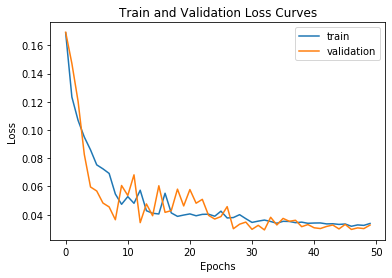

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import numpy as np
import matplotlib.pyplot as plt


model = Sequential()

model.add(LSTM(units = 50, return_sequences=False, input_shape=[None,4]))
model.add(Dense(units = 1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, 
                    epochs=50, batch_size=8, 
                    validation_data=(X_test, y_test), 
                    verbose=0, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.title("Train and Validation Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

We can see the performance of the model in the following graph:

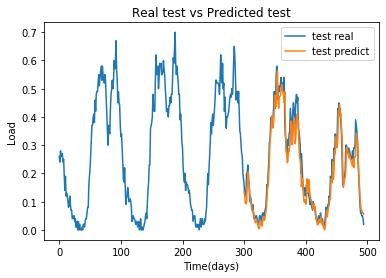

In [46]:
plt.plot(y_test, label='test real')
plt.plot(range(300,495), model.predict(X_test[300:], verbose=0).flatten(), label='test predict')
plt.title("Real test vs Predicted test")
plt.xlabel("Time(days)")
plt.ylabel("Load")
plt.legend()
plt.show()

(TBD: performance gains? which are the key aspects to be migrated into q? pandas queries ... anything else? What I'd like is something like: it's clear what we have to do: read and clean tables, etc. This is done in python using pandas, using ... whatever. What we are going to do is to do this part using qsql, this other using ... You have to think of the following situation: with all you know now, you are requested to tell someone how to migrate some pythonic code into pykx, what would you tell her to start from? which things are the most important one to migrate? etc.)

Done but needs revision vvvvvvvvvvvvvv

As discussed earlier, all 3 bottlenecks were solved by migrating to the kdb+/q environment taking advantage of PyKX. Overall, the final picture looks like this:


|                  | Pandas Time      |  PyKX Time       |
| ---------------- | ---------------- | ---------------- |
| Cleaning Weather | 247 ms ± 10.4 ms | 26.7 ms ± 683 µs |
| Cleaning Traffic | 33.6 s ± 493 ms  | 2.97 s ± 248 ms  |
| Join Final Table | 7.1 s ± 168 ms   | 686 ms ± 24.1 ms |

So we got a 10x decrease across the board. We went fron a total of 41 seconds spent on these bottlenecks down to just shy of 4 seconds, which is really impressive on itself. If a migration like this one was on the horizon, we would strongly suggest profiling the code to see where it struggles the most and try to think of a way to migrate those parts alone to PyKX. Then, as a second step, we recommend to port the rest of the code to PyKX in order to circumvent the overhead that moving data between memory spaces inherently adds to the process.

<div class="alert alert-block alert-info">
    <b> 🔍 You can find on Github the resulting <a href="https://github.com/hablapps/AllRoadsLeadToPyKX/blob/Python-Version-Pre/AllRoadsLeadToPyKX.md">PyKX-enhanced pythonic code</a>. </b> (TBD: fix url)
</div>


## pykx.q migration <a class="anchor" id="t4"></a>


After gaining proficiency in the q language, the team progressively shifted towards utilizing `kx.q()` extensively, drawn by its brevity. Yet, this approach introduced a level of monotony due to the requirement of employing strings. As a remedy, a decision was made to transition into a q environment. However, as highlighted in the previous chapter, certain Python code proved challenging to migrate to q. Consequently, the team chose to remain within PyKX, this time operating within a q environment.

pykx.q facilitates the execution of Python code within a q environment, thereby presenting new avenues for addressing existing codebases. This flexibility enables the incorporation and utilization of Python libraries, both those installed on the system and those available as .py files.

In our scenario, we harness both of these options. We emphasize the potential provided by these opportunities to integrate Python code within pykx.q, while also providing a link to the project's [q script]() for readers seeking further insights.

<div class="alert alert-block alert-info">
    <b> 🔍 You can find on Github the resulting <a href="https://github.com/hablapps/AllRoadsLeadToPyKX/blob/Python-Version-Pre/AllRoadsLeadToPyKX.md">PyKX-enhanced kdb+/q code</a>. (TBD: fix url)</b>
</div>

Our initial step involves executing the `haversine_vector` function for calculating coordinate distances. Given its unavailability in q, we opted to employ pykx.q to seamlessly integrate this library directly into our q code. This was achieved through the following lines:

```q
.pykx.pyexec"from haversine import haversine_vector, Unit";
```

This function expects two Pandas DataFrames as input, so we need to change the default conversion type from "np" or Numpy to "pd" or Pandas:

```q
.pykx.setdefault"pd";
```

Having done this, we can "move" our input variables to the Python memory space using `.pykx.set`

```q
.pykx.set[`a;`longitude`latitude#a];
.pykx.set[`b;`longitude`latitude#b];
```

And finally execute our function:

```q
(.pykx.eval"haversine_vector(a, b, Unit.KILOMETERS, comb=True)")`
```

Notice the backtick at the end, this is for converting back to a q type.



The other way we can run Python code is to load a .py (renamed to .p) file using `\l`. This could be done as follows:

```q
system"l kerasmodel.p";
```

Here we have defined two functions named `fit` and `predict`. We can load them and use them like this:

```q
modelfit:.pykx.get`fit;
modelfit[train[0][3403];train[1][3403];test[0][3403];test[1][3403]];
modelpredict:.pykx.get`predict;
res:modelpredict[train[0][3403]];
```

(TBD) Some performance results from this version?

## Final thoughts <a class="anchor" id="t5"></a>

Ultimately, the project yielded remarkable success. We effectively transformed a previously disorganized and performance-constrained codebase into a streamlined, competitive solution, enriched by the capabilities of kdb+/q. PyKX's design is conducive to harmonious coexistence between more seasoned professionals and newcomers in the realm of kdb+/q development. This fosters collaborative synergy among team members with varying levels of expertise. The diverse integration levels of PyKX, combined with their compatibility, make it an accessible entry point to kdb+/q for less-experienced colleagues, thereby enhancing our team's collective skill set.

The pykx.q library allows, as we have discussed earlier, to use existing Python codebases. This feature is really useful, specially when dealing with code migrations from Python. Through our experience, we identified challenges in aligning Python input shapes with their counterparts converted from q. After using the `.pykx.set` function for conversion to Python, we often needed to manipulate these transformed objects within the Python environment or modify the default conversion type to match the expected input format of Python functions.. Once that was dealt with, the experience using this library was really nice and technically impressive.

Since the data we needed to transfer back and forth between memory spaces was not that big (we were cautious this was the case) we observed no perceptible loss in performance. Instead, we achieved a significant improvement compared to Pandas.

Overall we would rate both PyKX libraries highly since it enables users to reuse existing code, significantly reducing the time required for migrations between these two languages.

## Bibliography <a class="anchor" id="t5"></a>

* *Vidas M, Tubić V, Ivanović I, Subotić M. Sustainability (Basel) 2022; 14(9): e4985, http://dx.doi.org/10.3390/su14094985*  
* *Y. Yao et al., "Analyzing the Effects of Rainfall on Urban Traffic-Congestion Bottlenecks," in IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, vol. 13, pp. 504-512, 2020, http://dx.doi.org/10.1109/JSTARS.2020.2966591*  
* *Essien, A., Petrounias, I., Sampaio, P., & Sampaio, S. (2018). The Impact of Rainfall and Temperature on Peak and Off-Peak Urban Traffic. In Database and Expert Systems Applications : 28th International Conference, DEXA 2018, Regensburg, Germany. (pp. 399-407). (Lecture Notes in Computer Science). Springer Nature.
https://doi.org/10.1007/978-3-319-98812-2_36*  
(TBD: new refs - need formatting .. )
* *A. Morrison and N. Crone, Accelerating Python Workflows using PyKX, June 2023, KX Developers blog, https://kx.com/blog/accelerating-python-workflows-using-pykx/*
* *Reuben Taylor. An Introduction to PyKXhttps://kx.com/videos/an-introduction-to-pykx/ June, 2023*
* *Paul Walsh PyKX Boosts Trade Analytics https://www.treliant.com/knowledge-center/pykx-boosts-trade-analytics/ June 26, 2023*

